In [2]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [3]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt

In [4]:
## Import standard packages
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [5]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [6]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [7]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [9]:
rolling_window = 10
market.connect()
prices = []
skips = 1
model_end = 2021
backtest_end = 2026
for ticker in tqdm(index["ticker"][::skips]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        price["market_cap"] = price["adjclose"] * price["volume"]
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price = p.additional_date_columns(price)
            price = price[(price["year"]>=model_end) & (price["year"]<backtest_end)]
            price.sort_values("date", inplace=True)
            price["standard_dev"] = 1
            price["coefficient_of_variation"] = 1
            price = Metric.NEXT_CLOSE.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_HIGH.calculate(price,timeframe=rolling_window)
            price = Metric.NEXT_LOW.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  2%|█████▋                                                                                                                                                                                                                             | 280/11272 [00:06<03:07, 58.62it/s]

'adjclose'


 15%|██████████████████████████████████▍                                                                                                                                                                                               | 1715/11272 [00:38<03:32, 45.01it/s]

'adjclose'


 34%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                    | 3878/11272 [01:28<02:30, 49.03it/s]

'adjclose'


 37%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 4218/11272 [01:37<02:37, 44.78it/s]

'adjclose'
'adjclose'


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 5061/11272 [02:00<02:24, 43.05it/s]

'adjclose'


 45%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                           | 5109/11272 [02:01<02:02, 50.27it/s]

'adjclose'


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 5247/11272 [02:04<01:56, 51.77it/s]

'adjclose'


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 5375/11272 [02:07<02:13, 44.20it/s]

'adjclose'


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11272/11272 [04:40<00:00, 40.24it/s]


In [10]:
simulation = pd.concat(prices)
simulation.sort_values("date", inplace=True)
simulation.columns

Index(['date', 'adjclose', 'high', 'low', 'volume', 'ticker', 'market_cap',
       'year', 'month', 'quarter', 'week', 'day', 'weekday', 'standard_dev',
       'coefficient_of_variation', 'next_close', 'next_high', 'next_low',
       'optimal', 'adr', 'sma', 'sma_corr', 'ema', 'ema_corr', 'health_check',
       'bollinger_upper', 'bollinger_lower', 'momentum', 'roc', 'williams_r',
       'obv', 'vwap', 'market_impact', 'atr'],
      dtype='object')

In [62]:
portfolios = PortfolioSelection.generate_possible_portfolios(
                                                            ranking_metrics=[
                                                                "ema","sma","roc","health_check"
                                                            ]
                                                            ,num_of_groups=[1]
                                                            ,group_percentages=[1]
                                                            ,max_prices=[0.1]
                                                            ,min_prices=[0.01]
                                                            ,max_market_caps = [1000]
                                                            ,min_market_caps = [0]
                                                            ,stoplosses=[1]
                                                            ,rolling_windows=[rolling_window]
                                                            ,leverages=[1]
                                                            )
filtered_portfolios = []
for portfolio in portfolios:
    if portfolio.timeframe.value == "day" and "blacklist" in portfolio.selection_type.label \
        and portfolio.allocation_type.label == "risk" \
        and portfolio.ranking_metric != "optimal" \
        and portfolio.position_type.label == "long" and ("standard_dev" in portfolio.grouping_type.value) \
        and portfolio.max_price > portfolio.min_price:
        filtered_portfolios.append(portfolio)

In [63]:
analysises = []
for portfolio in tqdm(filtered_portfolios):
    try:
        trades = portfolio.trades(simulation.copy())
        trades = p.additional_date_columns(trades)
        trades = trades.groupby("weekday").agg({"date":"last","weighted_return":"mean","return":"mean"}).reset_index().sort_values("date")
        trades["date"] = trades.apply(lambda row: datetime.strptime(f"{2025} {10} {row['weekday']+1}", "%Y %W %u"), axis=1)
        trades = p.additional_date_columns(trades)
        trades.sort_values("date")
        performance = portfolio.portfolio(trades.copy(),benchmark.copy())
        metrics = KPI.performance(trades,performance)
        results = {**portfolio.to_dict(),**metrics.copy()}
        results["portfolio"] = portfolio
        analysises.append(results)
    except Exception as e:
        print(str(e))
        continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:46<00:00, 13.26s/it]


In [64]:
a = pd.DataFrame(analysises)

In [65]:
metric = "raw_pnl"
dropped_columns = ["date","risk_type","max_price","min_price","max_market_cap","min_market_cap","timeframe","selection_percentage","rolling_window","portfolio"]
filtered_a = a.drop(dropped_columns,axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,allocation_type,stoploss,num_of_groups,leverage,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,sharpe_ratio,tracking_error,information_ratio
0,ema,long,STANDARD_DEV,top_blacklist,risk,1,1,1,4.195035,5.089982,1.298321,3.660556,1.146010,2.787131,1.146368,2.786263
2,sma,long,STANDARD_DEV,top_blacklist,risk,1,1,1,4.173592,5.039673,1.299119,3.681172,1.133767,2.798316,1.134314,2.796967
5,roc,long,STANDARD_DEV,bottom_blacklist,risk,1,1,1,3.455331,4.279436,1.221459,3.912558,0.883139,2.779153,0.883931,2.776662
7,health_check,long,STANDARD_DEV,bottom_blacklist,risk,1,1,1,2.750063,3.185854,1.217153,4.520726,0.608323,2.875296,0.609468,2.869897
6,health_check,long,STANDARD_DEV,top_blacklist,risk,1,1,1,0.641519,0.698161,0.892964,6.655734,0.096386,-3.729125,0.094767,-3.792821
4,roc,long,STANDARD_DEV,top_blacklist,risk,1,1,1,0.536126,0.561147,0.856319,4.301965,0.124624,-3.729854,0.121941,-3.811915
3,sma,long,STANDARD_DEV,bottom_blacklist,risk,1,1,1,0.435206,0.463192,0.824251,2.854604,0.152458,-3.710853,0.149800,-3.776688
1,ema,long,STANDARD_DEV,bottom_blacklist,risk,1,1,1,0.436451,0.462161,0.830666,2.839249,0.153721,-3.672263,0.150990,-3.738687


In [66]:
pm = top["portfolio"]
trades = pm.trades(simulation.copy())
trades = p.additional_date_columns(trades)
trades = trades.groupby("day").agg({"date":"last","weighted_return":"mean","return":"mean","market_cap":"mean"}).reset_index().sort_values("date")
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

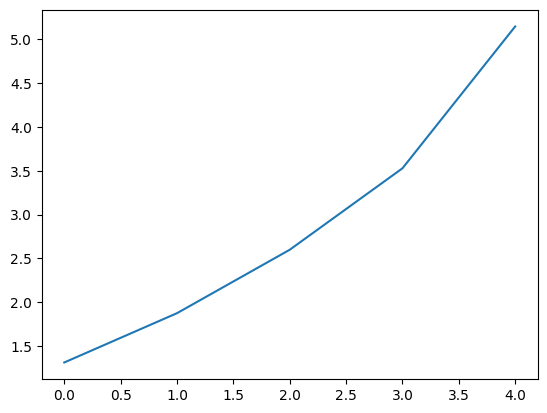

In [67]:
averaged_portfolio = portfolio.groupby("weekday").agg({"weighted_return":"mean","return":"mean"}).reset_index()
averaged_portfolio["pv"] = averaged_portfolio["weighted_return"]
plt.plot(averaged_portfolio["pv"].cumprod())
plt.show()

In [68]:
orivault.connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()